## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Load camera calibration matrix

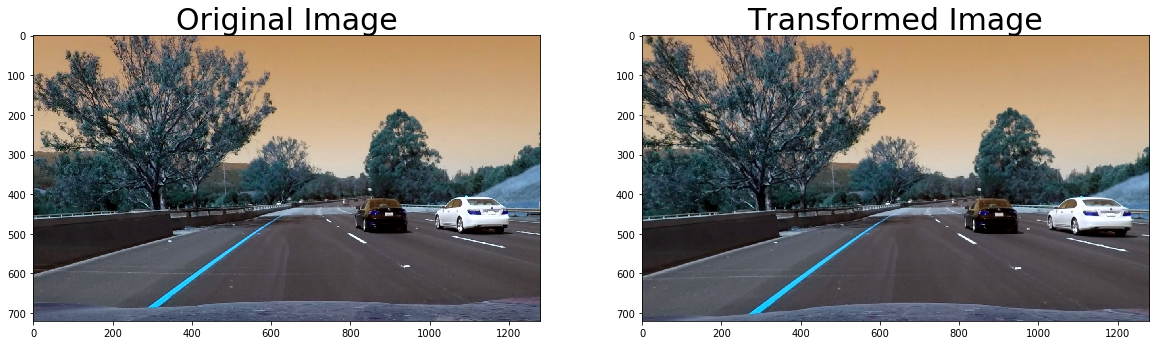

In [1]:
# Open camera distortion
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

with open('camera_cal/wide_dist_pickle.p', 'rb') as f:
    dist_pickle = pickle.load(f)
    
mtx, dist = dist_pickle["mtx"], dist_pickle["dist"]

# Test undistortion on an image
img = cv2.imread('test_images/test6.jpg')
img_size = (img.shape[1], img.shape[0])

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

def visualize(img, new_img):
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(new_img)
    ax2.set_title('Transformed Image', fontsize=30)

def visualize_gray(img, new_img):
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(new_img, cmap='gray')
    ax2.set_title('Transformed Image', fontsize=30)

visualize(img, dst)

## Create warper function. This will only be applied later

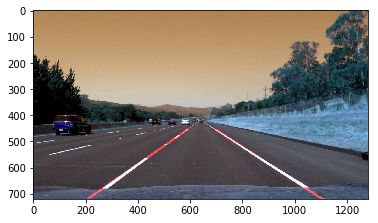

In [44]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, M

persp_test = cv2.imread('test_images/straight_lines2.jpg')

line_img = np.zeros((persp_test.shape[0], persp_test.shape[1], 3), dtype=np.uint8)
# Points on the image
tl = (590, 455) #top right
tr = (persp_test.shape[1] - 582, 455) #top left
bl = (208, persp_test.shape[0]) #bottom right
br = (persp_test.shape[1] - 174, persp_test.shape[0]) #bottom left

cv2.line(line_img, tr, br, [255,0,0], 7)
cv2.line(line_img, tl, bl, [255,0,0], 7)
result = cv2.addWeighted(line_img, 0.8, persp_test, 1., 0.)
plt.imshow(result)

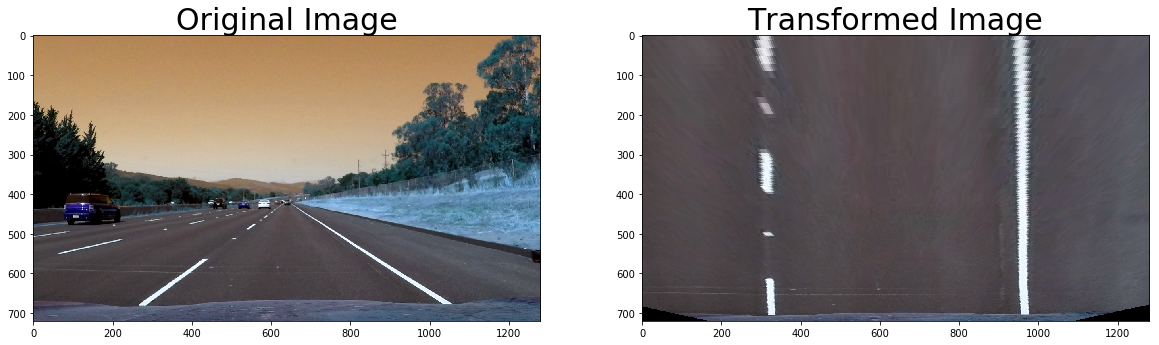

In [45]:
# For source points I'm looking at example straight line images
# After making sure this works, I should use the draw_lines function from the first project to get the points
source = np.float32([tl, bl, br, tr])
# For destination points, I'm arbitrarily choosing some points to be a nice fit for displaying the warped result 
# Not exact, but close enough for our purposes. Dividing by four is a good aproximation
destination = np.float32([(persp_test.shape[1]/4, 0), (persp_test.shape[1]/4, persp_test.shape[0]), (persp_test.shape[1]*3/4, persp_test.shape[0]), (persp_test.shape[1]*3/4, 0)])

warped, M = warper(persp_test, source, destination)
visualize(persp_test,warped)


## Gradient thresholds

In [46]:
def abs_sobel_thresh(image, orient, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    elif orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
    else:
        raise ValueError("orient must be 'x' or 'y'")
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

In [47]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mg_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mg_sobel/np.max(mg_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

In [48]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # mg_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(gray)
    dir_binary[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary

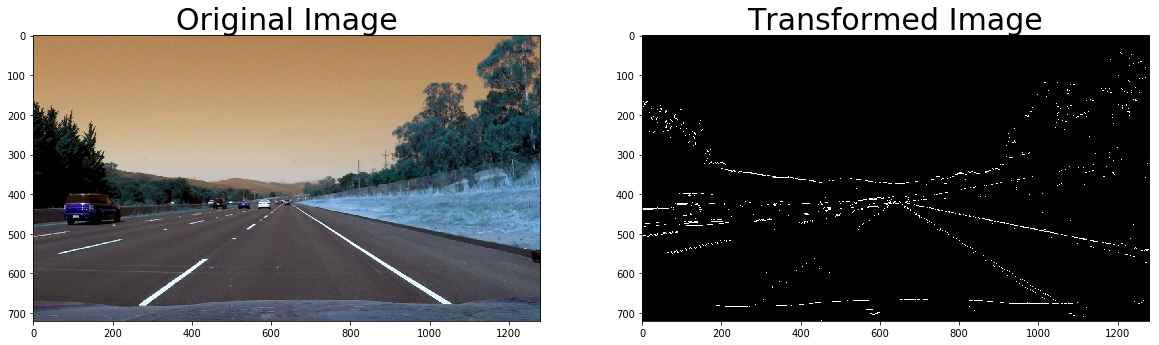

In [49]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(persp_test, orient='x', sobel_kernel=3, thresh=(200, 255))
grady = abs_sobel_thresh(persp_test, orient='y', sobel_kernel=3, thresh=(100, 200))
mag_binary = mag_thresh(persp_test, sobel_kernel=3, mag_thresh=(50, 120))
dir_binary = dir_threshold(persp_test, sobel_kernel=15, thresh=(1, 2))

# Combining thresholds
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plotting results
visualize_gray(persp_test, combined)


## Color spaces transforms

In [50]:
def lightness_thresh(image, l_thresh=(200,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    return l_binary

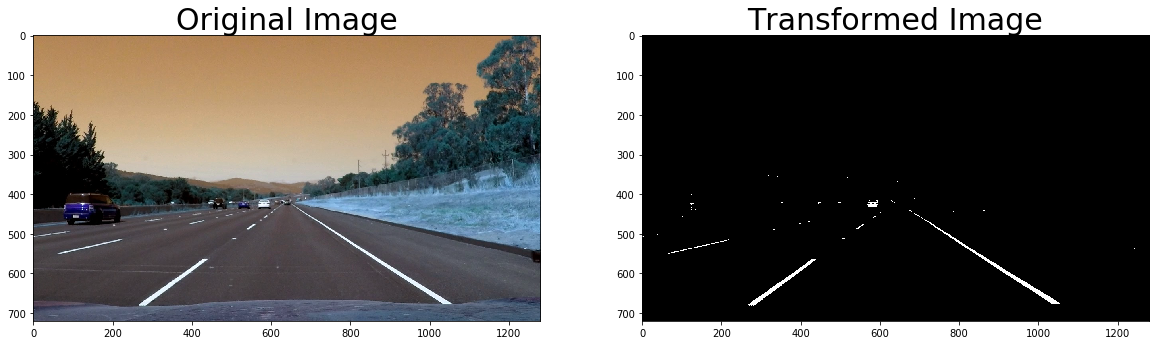

In [51]:
light = lightness_thresh(persp_test)
# Plotting results
visualize_gray(persp_test, light)

## Process image

In [52]:
img_size = (light.shape[1], light.shape[0])
binary_warped = cv2.warpPerspective(light, M, img_size, flags=cv2.INTER_NEAREST)


In [53]:
def windows_search(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # SEPARATE PLOTTING
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    # SEPARATE CURVATURE
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    
    # SEPARATE REAL WORLD CONVERSIONS
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_fit, right_fit


In [54]:
# Window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    print(warped.shape)
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [55]:

window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

(720, 1280)


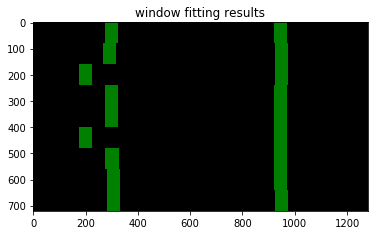

In [56]:
# If we found any window centers
if len(window_centroids) > 0:
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(binary_warped)
    r_points = np.zeros_like(binary_warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    # If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)
    
# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

66829.0206845 24470.5289995
21949.6400018 m 8017.93267745 m


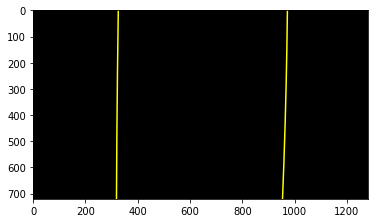

In [28]:
# left_fit, right_fit = windows_search(binary_warped)
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
clip = VideoFileClip("project_video.mp4")
# function to find lane lines   vvv
test_clip = clip.fl_image(process_image)

test_clip.write_videofile(test_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>    
""".format(test_output))
# video here   ^^^